In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from doubt import Boot, QuantileRegressor
import numpy as np
from types import MethodType
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
rng = np.random.RandomState(42)
from typing import Sequence, Tuple, Union, Optional
from scipy.optimize import minimize
FloatMatrix = Sequence[Sequence[float]]
FloatArray = Sequence[float]

## I'll overload the doubt.QuantileRegressor.fit method with this later on. Changes highlighted below.
def fit(self,
        X: FloatMatrix,
        y: FloatArray,
        random_seed: Optional[int] = None):
    '''Fit the model.
    Args:
        X (float matrix):
            The array containing the data set, either of shape (n,) or
            (n, f), with n being the number of samples and f being the
            number of features.
        y (float array):
            The target array, of shape (n,).
    '''
    # Convert inputs to Numpy arrays
    X_arr = np.asarray(X)
    y_arr = np.asarray(y)

    # Fit the scaler and scale `X`
    self._scaler.fit(X_arr)
    X_arr = self._scaler.transform(X_arr)

    # Fit the underlying model
    self._model.fit(X_arr, y_arr)

    # Add constant feature
    X_arr = np.concatenate((X_arr, np.ones((X_arr.shape[0], 1))), axis=1)

    # When a Scikit-Learn GLM is fitted then its link function is set to
    # the attribute _link_instance. As the LinearRegression class does not
    # subclass the GeneralizedLinearRegressor class then we deal with this
    # case separately
    try:
        link = self._model._link_instance
        self._inverse_link_function = link.inverse
    except AttributeError:
        # ----------------------------------------------------------#
        # CHANGE ONE: LINK FUNCTION FOR LOGISTIC REGRESSION
        if isinstance(self._model, LinearRegression):
            self._inverse_link_function = lambda x: x
        elif isinstance(self._model, LogisticRegression):
            self._inverse_link_function = lambda x: 1 / (1 + np.exp(-x))

    # Use the underlying GLM's parameters for the initial guess of the
    # quantile weights
    # ---------------------------------------------------------------#
    # CHANGE TWO: FOR SOME REASON, LOGISTIC REGRESSION RETURNS COEFFICIENTS TRANSPOSED
    if isinstance(self._model, LogisticRegression):
        model_weights = self._model.coef_.T
    else:
        model_weights = self._model.coef_
    model_intercept = self._model.intercept_
    beta_init = np.concatenate((model_weights, [model_intercept]))

    # Fit all quantile estimates
    for q in self.quantiles:

        # Initialise random seed, which is used by SciPy
        if random_seed is not None:
            np.random.seed(random_seed)

        args = (X_arr, y_arr, q, self._inverse_link_function)
        result = minimize(self._objective_function,
                          beta_init,
                          args=args,
                          method='BFGS',
                          options={'maxiter': self.max_iter})
        self._weights[q] = result.x

    return self

#### Example setup
In this example, we have two groups (blue and red).
In both groups, the risk rises linearly with some observed quantity x.
However, the baseline risk is higher in the red group, and, moreover, the risk of the red group is also influenced by an unobserved binary confounder (indicated by the marker type in the plot). Thus, the risk of subjects in the red group can only be estimated with higher (aleatoric) uncertainty compared to the blue group.

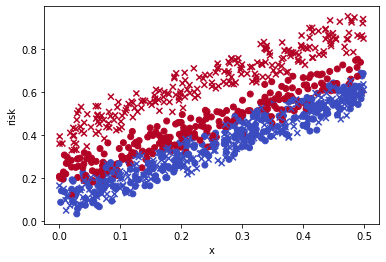

In [12]:
def risk(x, group, confounder):
    """The true risk of each sample"""
    return 0.1 + 0.1*group + x + 0.2*group*confounder

x = np.atleast_2d(rng.uniform(0, 0.5, size=1000)).T
group = np.atleast_2d(rng.binomial(1, 0.5, size=1000)).T
confounder = np.atleast_2d(rng.binomial(1, 0.5, size=1000)).T
expected_risk = risk(x, group, confounder)
lower, upper = -0.1, 0.1
mu, sigma = 0, 0.05
risk_noise = np.atleast_2d(stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(1000)).T
true_risk = expected_risk + risk_noise
outcomes = rng.binomial(1, p=true_risk)
markertypes = ['o', 'x']
cmap = matplotlib.cm.get_cmap('coolwarm')
groupnames = ['Class 0 / blue', 'Class 1 / red']
for i in [0, 1]:
    mask = confounder == i
    plt.scatter(x[mask], true_risk[mask], c=group[mask], marker=markertypes[i], cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('risk')
plt.show()

In [13]:
# prepare data for estimation + plotting
X_train, X_test, y_train, y_test, risk_train, risk_test, confounder_train, confounder_test = train_test_split(
    np.concatenate((x, group), axis=1), outcomes, true_risk, confounder, test_size=0.25, random_state=rng)
idces = np.argsort(X_test[:, 0], axis=0)
X_test = np.atleast_2d(X_test[idces, :].squeeze())
y_test = np.atleast_2d(y_test[idces, :].squeeze()).T
risk_test = np.atleast_2d(risk_test[idces, :].squeeze()).T
confounder_test = np.atleast_2d(confounder_test[idces, :].squeeze()).T

def plot_results(risk_test_pred, risk_test_pred_bounds, group, confounder):
    group = group.squeeze()
    confounder = confounder.squeeze()
    plt.figure()
    for i in [0, 1]:
        mask = confounder == i
        plt.scatter(risk_test_pred[mask], risk_test[mask], c=group[mask], marker=markertypes[i], cmap='coolwarm')
    plt.xlabel('predicted risk')
    plt.ylabel('true risk')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1], '--')
    
    plt.figure(figsize=(12.8, 4.8))
    for group_val in [0, 1]:
        plt.subplot(1, 2, group_val+1)
        group_mask = group == group_val
        for i in [0, 1]:
            mask = (confounder == i) & group_mask
            plt.scatter(X_test[mask, 0], risk_test[mask] - risk_test_pred[mask], color=cmap(group_val), marker=markertypes[i])
        plt.plot(X_test[group_mask, 0], risk_test_pred_bounds[group_mask, :] - risk_test_pred[group_mask], "k-")
        plt.fill_between(
            X_test[group_mask, 0].ravel(), 
            risk_test_pred_bounds[group_mask, 0] - risk_test_pred[group_mask].squeeze(), 
            risk_test_pred_bounds[group_mask, 1] - risk_test_pred[group_mask].squeeze(), 
            alpha=0.4)
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title(groupnames[group_val])

def evaluate(risk_test, risk_pred, risk_test_pred_bounds):
    # Quantify coverage of the prediction interval
    above_bound_mask = np.squeeze(risk_test) > np.squeeze(risk_test_pred_bounds[:, 1])
    below_bound_mask = np.squeeze(risk_test) < np.squeeze(risk_test_pred_bounds[:, 0])
    outside_bound_mask = above_bound_mask | below_bound_mask
    print(f'Coverage: {(1-sum(outside_bound_mask)/len(risk_test))*100:.2f}%')
    # Also quantify general performance
    print(f'MSE: {((risk_test - risk_pred)**2).mean():.2f}')

#### Attempt 1: Logistic Regression + Bootstrapping

Coverage: 100.00%
MSE: 0.01


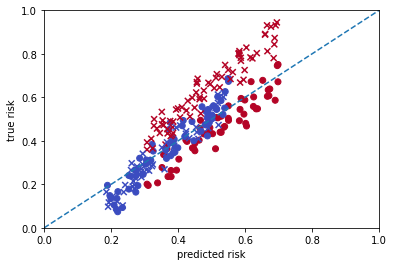

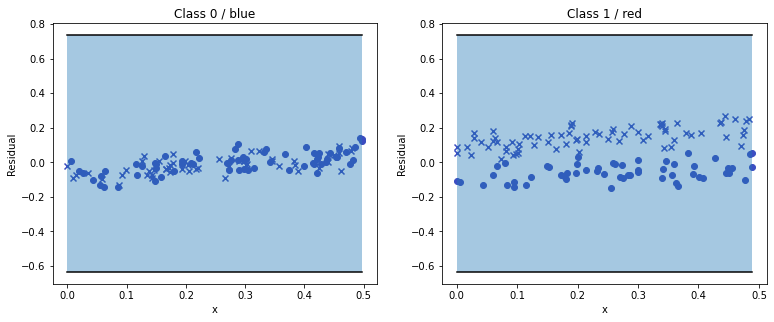

In [14]:
# Boot is only implemented for regression models and works with the predict() method. 
# LogisticRegression's predict() methods returns the estimated class labels, however (assuming a default threshold of .5).
# To make Boot work with this, overload the predict() method with predict_proba().
# Also, predict_proba() returns an [N, 2] vector with the probabilities for the two classes; we reduce that to an [N, 1] vector.
LR = LogisticRegression()
LR.predict = lambda *args: LR.predict_proba(*args)[:, 1]
model = Boot(LR)
model.fit(X_train, y_train.ravel())
risk_test_pred, risk_test_pred_bounds = model.predict(X_test, uncertainty=0.05)
risk_test_pred = np.atleast_2d(risk_test_pred).T
plot_results(risk_test_pred, risk_test_pred_bounds, X_test[:, 1], confounder_test)
evaluate(risk_test, risk_test_pred, risk_test_pred_bounds)

While the fitting generally seems to work (yay!), the prediction intervals are totally off. (Note that they return values above 1 and below 0, which can obviously never occur.) How does that happen? Am I doing something wrong or does it have something to do with the method? (I tried the same thing with an xgboost model - not shown here - with similar results.)

#### Atempt 2: Quantile logistic regression

Coverage: 100.00%
MSE: 0.01


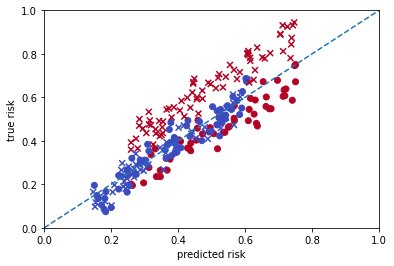

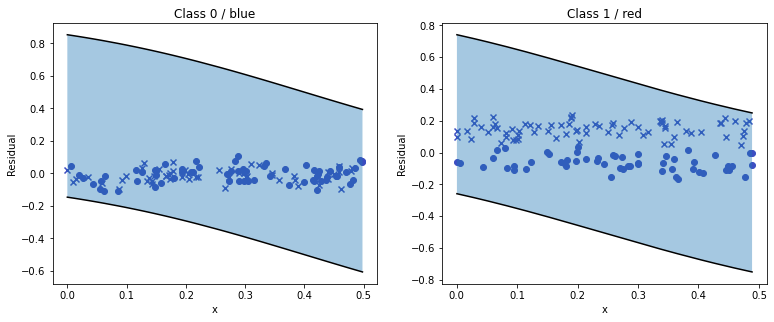

In [15]:
LR = LogisticRegression()
LR.predict = lambda *args: LR.predict_proba(*args)[:, 1]
model = QuantileRegressor(LR, uncertainty=0.05)
model.fit = MethodType(fit, model)
model.fit(X_train, y_train.ravel())
risk_test_pred, risk_test_pred_bounds = model.predict(X_test)
risk_test_pred = np.atleast_2d(risk_test_pred).T
plot_results(risk_test_pred, risk_test_pred_bounds, X_test[:, 1], confounder_test)
evaluate(risk_test, risk_test_pred, risk_test_pred_bounds)

The prediction intervals basically always cover the whole [0, 1] range. Again, am I doing something wrong? Does this not make sense for some reason?